In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from string import ascii_uppercase as letters
from pathlib import Path

Using TensorFlow backend.


In [9]:
def get_runs(out_folder, logfile='log.pkl'):
    run_params = pickle.load(open(os.path.join(out_folder, logfile), 'rb'))
    epochs = run_params['epochs']
    units = run_params['units']
    
    runs = []
    for filename in [os.path.join(out_folder, f'{epochs[i]}it_{units[i]}units_{i+1}layers.pkl') for i in range(3)]:
        with open(filename, 'rb') as f:
            runs.append(pickle.load(f))
    return runs, run_params

def get_mean_vectors(history):
    test_loss = []
    train_loss = []
    for run in history:
        test_loss.append(run['val_loss'])
        train_loss.append(run['loss'])
    
    test_mean = np.array(test_loss).mean(axis=0)
    train_mean = np.array(train_loss).mean(axis=0)

    return test_mean, train_mean

def get_std_vectors(history):
    test_loss = []
    train_loss = []
    for run in history:
        test_loss.append(run['val_loss'])
        train_loss.append(run['loss'])
        
    test_std = np.array(test_loss).std(axis=0)
    train_std = np.array(train_loss).std(axis=0)
    
    return test_std, train_std

def get_hyperparameters(filepath, layers=range(3), units=[2**i for i in range(5,9)]):
    epochs_list = []
    units_list = []
    losses = []
    for layer in layers:
        val_loss_contour = []
        for unit in units:
            history = pickle.load(open(os.path.join(filepath, f'{layer}layers_{unit}units.pkl'), 'rb'))
            val_loss, loss = get_mean_vectors(history)
            val_loss_contour.append(val_loss)
    
        Z = np.array(val_loss_contour)
        argmin = np.unravel_index(Z.argmin(), Z.shape)
        units_list.append(units[argmin[0]])
        epochs_list.append(argmin[1]+1)
        losses.append(Z.min())
    
    return units_list, epochs_list, losses

In [3]:
runs = [
    'runs/ALPHA/FFWD/get_distr_j_encoding', #0
    'runs/ALPHA/FFWD/get_one_hot_encoding', #1
    'runs/ALPHA/FFWD/get_orthogonal_encoding', #2
    'runs/ALPHA/LSTM/get_distr_j_encoding', #3
    'runs/ALPHA/LSTM/get_one_hot_encoding', #4
    'runs/ALPHA/LSTM/get_orthogonal_encoding', #5
    'runs/MNIST/alpha_0/FFWD/1ep', #6
    'runs/MNIST/alpha_0/FFWD/12ep', #7
    'runs/MNIST/alpha_0/LSTM/1ep', #8
    'runs/MNIST/alpha_0/LSTM/12ep', #9
    'runs/MNIST/alpha_1/FFWD/1ep', #10
    'runs/MNIST/alpha_1/FFWD/97ep', #11
    'runs/MNIST/alpha_1/LSTM/1ep', #12
    'runs/MNIST/alpha_1/LSTM/97ep', #13
    'runs/ALPHA/FFWD/get_distr_j_encoding/SGD', #14
    'runs/ALPHA/FFWD/get_one_hot_encoding/SGD', #15
    'runs/ALPHA/FFWD/get_orthogonal_encoding/SGD' #16
]

encodings_dict = {
    'get_distr_j_encoding': 'Distributed',
    'get_one_hot_encoding': 'One-Hot',
    'get_orthogonal_encoding': 'Haar'
}

alpha_encodings_dict = {
    'alpha=0': 'jamais vu',
    'alpha=1': 'déjà vu'
}

# View Bar Plots

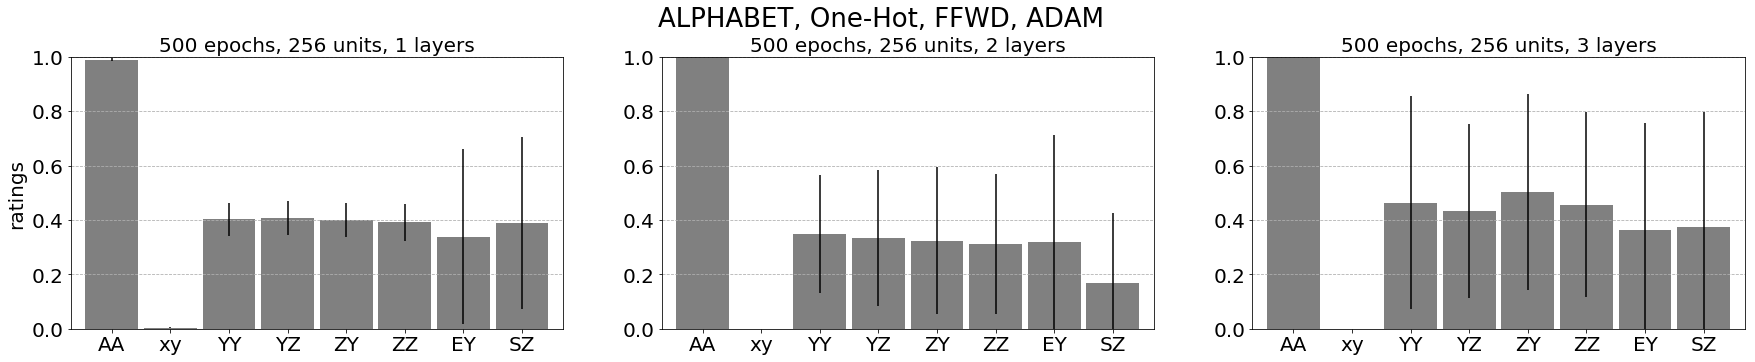

In [6]:
run_path = runs[1]
run1, run_params = get_runs(run_path)

epochs = run_params['epochs']
units = run_params['units']
encoding_name = encodings_dict[run_params['encoding']] if 'encoding' in run_params.keys() else \
    ', '.join([alpha_encodings_dict[Path(run_path).parts[2].replace('_','=')], Path(run_path).parts[4].replace('ep',' Epoch')])

fig,ax = plt.subplots(1,3,figsize=(30,5))
plt.setp(ax, ylim=(0,1))

suptitle = '{}, {}, {}, {}'.format('ALPHABET' if run_params['data_type']=='ALPHA' else 'MNIST',
                                   encoding_name, 
                                   run_params['model_type'], 
                                   run_params['optimizer_type'])
fig.suptitle(suptitle, fontsize=26, y=1.02)

for i,run in enumerate(run1):
    df = run['df_list'].T
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    df['mean'].plot(kind='bar',width=0.9, color='grey', ax=ax[i], yerr=df['std'])

    ax[i].set_title(f'{epochs[i]} epochs, {units[i]} units, {i+1} layers', fontsize=20)
    ax[i].tick_params(labelsize=20,rotation=0)
    ax[i].grid(axis='y',linestyle='--')

fig.text(0.1,0.5, 'ratings', ha="center", va="center", rotation=90, fontsize=20)
#plt.savefig(os.path.join('bar_plots', suptitle.replace(', ', '_').replace(' ','_')), bbox_inches='tight')
plt.show()

# View Loss Plots

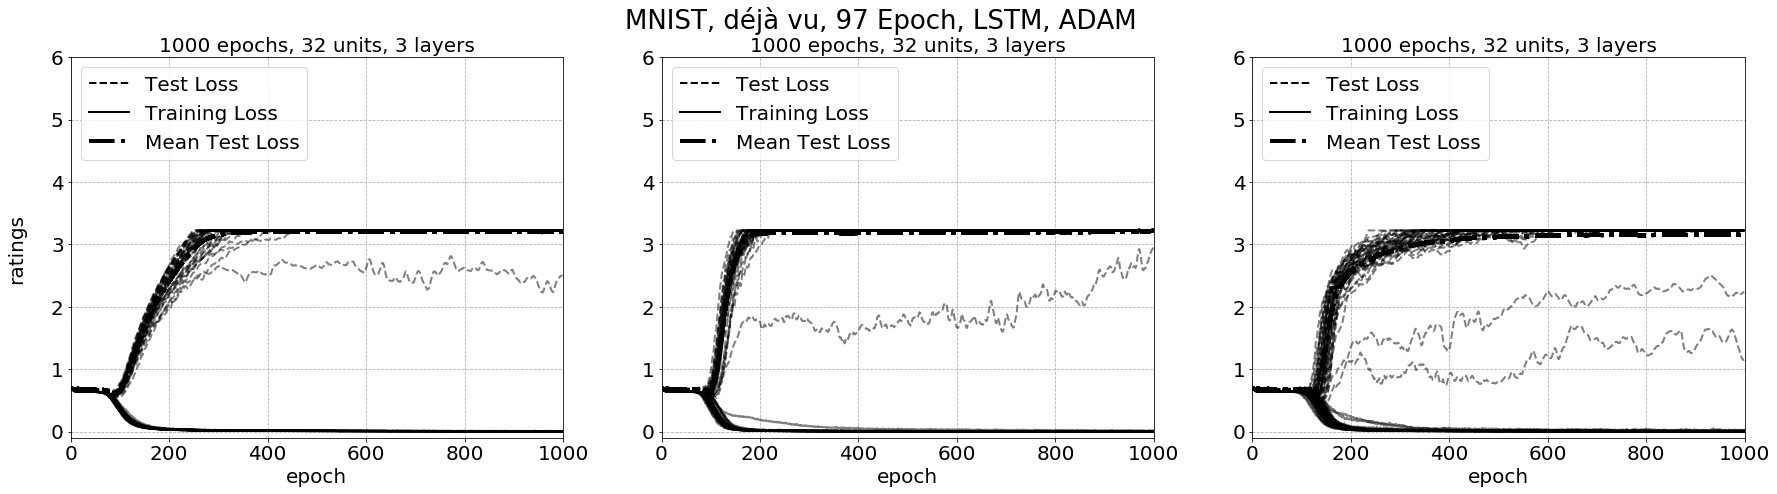

In [10]:
run_path = runs[13]
run1, run_params = get_runs(run_path)

epochs = run_params['epochs']
units = run_params['units']
encoding_name = encodings_dict[run_params['encoding']] if 'encoding' in run_params.keys() else \
    ', '.join([alpha_encodings_dict[Path(run_path).parts[2].replace('_','=')], Path(run_path).parts[4].replace('ep',' Epoch')])

fig,ax = plt.subplots(1,3,figsize=(30,7))
plt.setp(ax, ylim=(-0.1,4 if run_params['model_type']=='FFWD' else 6))

suptitle = '{}, {}, {}, {}'.format('ALPHABET' if run_params['data_type']=='ALPHA' else 'MNIST',
                                   encoding_name, 
                                   run_params['model_type'], 
                                   run_params['optimizer_type'])
fig.suptitle(suptitle, fontsize=26)

for layer in range(3):
    for history in run1[layer]['history_list']:
        loss_mean,_ = get_mean_vectors(run1[layer]['history_list'])
        ax[layer].plot(history['val_loss'], linestyle='dashed', color='black', alpha=0.5, linewidth=2, label='Test Loss')
        ax[layer].plot(history['loss'], linestyle='solid', color='black', alpha=0.5, linewidth=2, label='Training Loss')
        ax[layer].plot(loss_mean, linestyle='dashdot', color='black', linewidth=4, label='Mean Test Loss')

    ax[layer].set_title(f'{epochs[i]} epochs, {units[i]} units, {i+1} layers', fontsize=20)
    ax[layer].tick_params(labelsize=20,rotation=0)
    ax[layer].grid(linestyle='--')
    ax[layer].set_xlim(0, len(loss_mean))
    ax[layer].set_xlabel('epoch', fontsize=20)

    val_loss = mlines.Line2D([], [], color='black', linestyle='dashed', linewidth=2, label='Test Loss')
    train_loss = mlines.Line2D([], [], color='black', linestyle='solid', linewidth=2, label='Training Loss')
    mean_test_loss = mlines.Line2D([], [], color='black', linestyle='dashdot', linewidth=4, label='Mean Test Loss')
    ax[layer].legend(handles=[val_loss,train_loss,mean_test_loss], loc='upper left', fontsize=20)

fig.text(0.1,0.5, 'ratings', ha="center", va="center", rotation=90, fontsize=20)
#plt.savefig(os.path.join('loss_plots', suptitle.replace(', ', '_').replace(' ','_')), bbox_inches='tight')
plt.show()

# View Comparison Plots

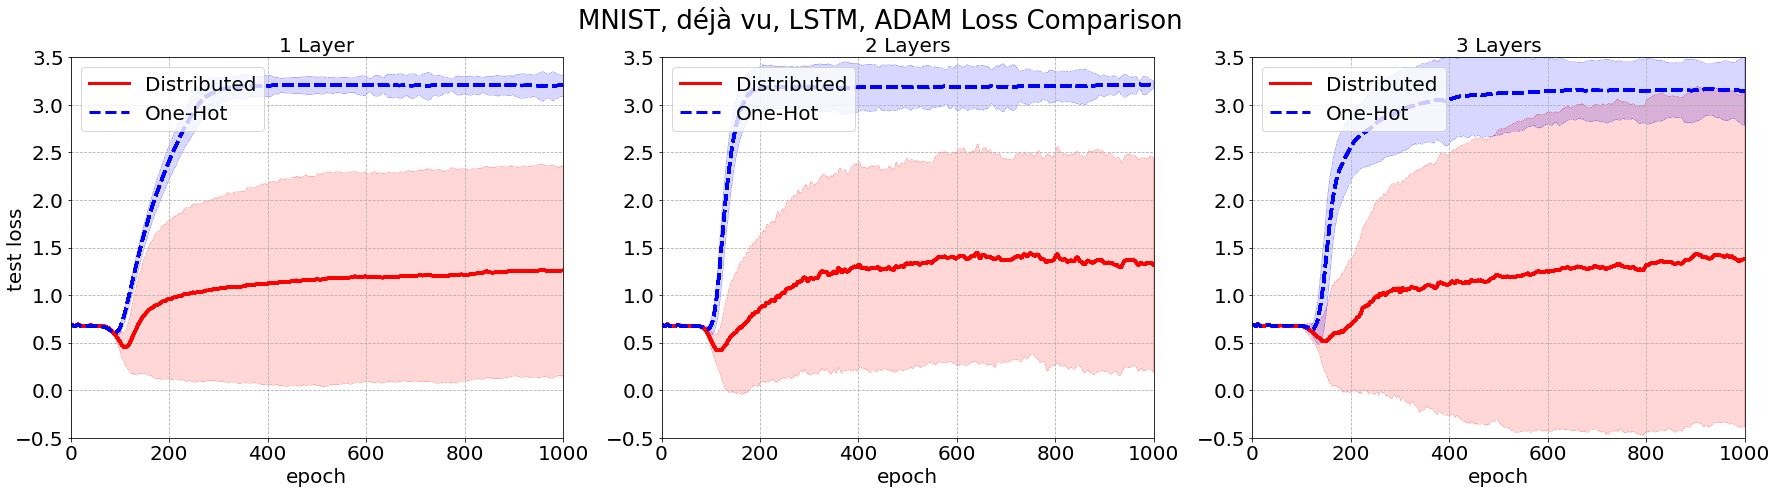

In [12]:
run_path_list = [runs[12], runs[13]]
run_list = []
run_params_list = []
encoding_name_list = []
run_name_list = []

for run in run_path_list:
    temp_run, temp_params = get_runs(run)
    run_list.append(temp_run)
    run_params_list.append(temp_params)

for run_path, run_params in zip(run_path_list, run_params_list):
    encoding_name_list.append(
        encodings_dict[run_params['encoding']] if 'encoding' in run_params.keys() else \
    ', '.join([alpha_encodings_dict[Path(run_path).parts[2].replace('_','=')], Path(run_path).parts[4].replace('ep',' Epoch')]))
    

for encoding_name, run_params in zip(encoding_name_list, run_params_list):
    run_name_list.append('{}, {}, {}, {}'.format('ALPHABET' if run_params['data_type']=='ALPHA' else 'MNIST',
                                                 encoding_name, 
                                                 run_params['model_type'], 
                                                 run_params['optimizer_type']))

colors = ['red', 'blue', 'green']
linestyles = ['solid', 'dashed', 'dashdot']
    
fig, ax = plt.subplots(1,3, figsize=(30,7))
if run_params['data_type']=='ALPHA':
    suptitle = '{}, {}, {} Loss Comparison'.format('ALPHABET',
                                                   run_params['model_type'],
                                                   run_params['optimizer_type'])
else:
    suptitle = '{}, {}, {}, {} Loss Comparison'.format('MNIST',
                                                       alpha_encodings_dict[Path(run_path).parts[2].replace('_','=')],
                                                       run_params['model_type'],
                                                       run_params['optimizer_type'])
    
fig.suptitle(suptitle, fontsize=26)

for layer in range(3):
    for i,run in enumerate(run_list):
        for history in run[layer]['history_list']:
            loss_std,_ = get_std_vectors(run[layer]['history_list'])
            loss_mean,_ = get_mean_vectors(run[layer]['history_list'])
            ax[layer].plot(loss_mean, linestyle=linestyles[i], color=colors[i], label=i, linewidth=3)
            ax[layer].fill_between(np.arange(len(loss_mean)), (loss_mean-loss_std), (loss_mean+loss_std), 
                                   color=colors[i], alpha=0.005)
            
        ax[layer].set_title('{} Layer{}'.format(layer+1, 's' if layer>0 else ''), fontsize=20)
        ax[layer].tick_params(labelsize=20)
        ax[layer].grid(linestyle='--')
        ax[layer].set_xlabel('epoch', fontsize=20)
        ax[layer].set_xlim(0, len(loss_mean))
        ax[layer].set_ylim(-0.5,3.5)

        line_list = []
        for i,label in enumerate(run_name_list):
            line_list.append(mlines.Line2D([], [], 
                                           color=colors[i], 
                                           linestyle=linestyles[i], 
                                           label='Distributed' if i==0 else ('One-Hot' if i==1 else 'Orthogonal'), 
                                           linewidth=3))
        ax[layer].legend(handles=line_list, loc='upper left', fontsize=20)
        
fig.text(0.1,0.5, 'test loss', ha="center", va="center", rotation=90, fontsize=20)
#plt.savefig(os.path.join('comparison_plots', suptitle.replace(', ','_').replace(' ','_')), bbox_inches='tight')
plt.show()